# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
from scipy import stats


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
%pip install pandas-datareader

# user written modules
import dataproject

import pandas_datareader 
import datetime


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [85]:
#Name/link to data in FRED 

#CPI data (Growth rate previous period, Not Seasonally Adjusted)
CPI_CAN = 'CPALTT01CAA657N'
CPI_USA = 'CPALTT01USA659N'
CPI_UK = 'CPALTT01GBA659N'

# Exchange rate 
EX_CAN = 'AEXCAUS' #(Canadian Dollars to One U.S. Dollar, Not Seasonally Adjusted)
EX_UK = 'AEXUSUK' #(U.S. Dollars to One U.K. Pound Sterling, Not Seasonally Adjusted)



In [86]:
# Need first to encode dates in a python friendly to specify the length of the desired time period. 
# Use the datetime module - it is the general way to handle dates in python. 
start = datetime.datetime(1990,1,1)
end = datetime.datetime(2020,1,1)
timespan = end - start # We can investigate the precise time span by just subtracting to time variables.
print('total number of days:', timespan.days) # The timespan object has a days attribute.

total number of days: 10957


In [108]:
# Call the FRED api using pandas_datareader 
inflation = pandas_datareader.data.DataReader([CPI_USA, CPI_UK, CPI_CAN], 'fred', start, end)
inflation = inflation.rename(columns = {'CPALTT01USA659N':'CPI_USA','CPALTT01GBA659N':'CPI_CA','CPALTT01CAA657N':'CPI_UK'})
inflation.head(5)

,CPI_USA,CPI_CA,CPI_UK
DATE,,,
1990-01-01,5.397956,8.0,4.780477
1991-01-01,4.234964,7.5,5.625864
1992-01-01,3.028820,4.6,1.490133
1993-01-01,2.951657,2.6,1.865079
1994-01-01,2.607442,2.2,0.165563


In [109]:
# Call the FRED api using pandas_datareader 
exchange = pandas_datareader.data.DataReader([EX_UK, EX_CAN], 'fred', start, end)
exchange = exchange.rename(columns = {'AEXUSUK':'USUK_EX','AEXCAUS':'CAUS_EX'})
exchange.head(5)

,USUK_EX,CAUS_EX
DATE,,
1990-01-01,1.7841,1.1668
1991-01-01,1.7674,1.1460
1992-01-01,1.7663,1.2085
1993-01-01,1.5016,1.2902
1994-01-01,1.5319,1.3664


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

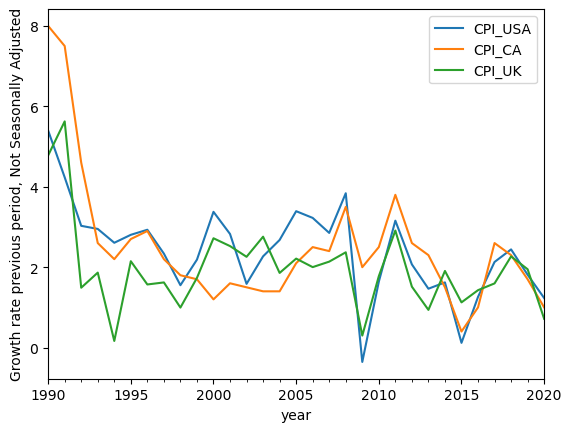

In [90]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Now we are just plotting directly from the pandas dataframe. Still using matplotlib under the hood.
inflation.plot(ax=ax)

ax.legend(frameon=True)
ax.set_xlabel('year')
ax.set_ylabel('Growth rate previous period, Not Seasonally Adjusted');

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

In [155]:
ppp = pd.merge(inflation, exchange, how = 'outer', on = ['DATE']); 
ppp['CA_pct_dif_from_USA_CPI'] = ((ppp.CPI_CA-ppp.CPI_USA) / ppp.CPI_USA) * 100 # the pct. difference between inflation in canada and USA
ppp['UK_pct_dif_from_USA_CPI'] = ((ppp.CPI_UK-ppp.CPI_USA) / ppp.CPI_USA) * 100 # the pct. difference between inflation in UK and USA
ppp['USUK_EX_DIF'] = (ppp['USUK_EX'].diff() / ppp['USUK_EX'].shift(1)) * 100 *(-1) #tjek vejen
ppp['CAUS_EX_DIF'] = ((ppp['CAUS_EX'].diff() / ppp['CAUS_EX'].shift(1)) * 100) #tjek vejen 
ppp.head(10)

,CPI_USA,CPI_CA,CPI_UK,USUK_EX,CAUS_EX,CA_pct_dif_from_USA_CPI,UK_pct_dif_from_USA_CPI,USUK_EX_DIF,CAUS_EX_DIF
DATE,,,,,,,,,
1990-01-01,5.397956,8.0,4.780477,1.7841,1.1668,48.204234,-11.439135,NaN,NaN
1991-01-01,4.234964,7.5,5.625864,1.7674,1.1460,77.097139,32.843258,0.936046,-1.782653
1992-01-01,3.028820,4.6,1.490133,1.7663,1.2085,51.874343,-50.801531,0.062238,5.453752
1993-01-01,2.951657,2.6,1.865079,1.5016,1.2902,-11.913883,-36.812462,14.986129,6.760447
1994-01-01,2.607442,2.2,0.165563,1.5319,1.3664,-15.626106,-93.650369,-2.017848,5.906061
1995-01-01,2.805420,2.7,2.148760,1.5785,1.3725,-3.757715,-23.406814,-3.041974,0.446429
1996-01-01,2.931204,2.9,1.570531,1.5607,1.3638,-1.064552,-46.420276,1.127653,-0.633880
1997-01-01,2.337690,2.2,1.621216,1.6376,1.3849,-5.890000,-30.648785,-4.927276,1.547148
1998-01-01,1.552279,1.8,0.995942,1.6573,1.4836,15.958528,-35.839988,-1.202980,7.126868


# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

Check and remove outliers

In [157]:
# Calculate z-scores for each data point
outlier_columns = ['CA_pct_dif_from_USA_CPI', 'UK_pct_dif_from_USA_CPI']
z_scores = stats.zscore(ppp[outlier_columns])
print(z_scores)

# Define a threshold for z-score
threshold = 3  # Adjust this threshold as needed

# Filter out rows where the absolute z-score exceeds the threshold
filtered_ppp = ppp[((z_scores < threshold) & (z_scores > -threshold)).all(axis=1)]
filtered_ppp = filtered_ppp.drop(filtered_ppp.index[0])
filtered_ppp.head()



            CA_pct_dif_from_USA_CPI  UK_pct_dif_from_USA_CPI
DATE                                                        
1990-01-01                 0.486010                -0.095479
1991-01-01                 0.708857                 0.182559
1992-01-01                 0.514318                -0.342625
1993-01-01                 0.022328                -0.254791
1994-01-01                -0.006304                -0.611662
1995-01-01                 0.085235                -0.170621
1996-01-01                 0.106007                -0.315116
1997-01-01                 0.068789                -0.216091
1998-01-01                 0.237304                -0.248685
1999-01-01                -0.057813                -0.153701
2000-01-01                -0.382984                -0.145892
2001-01-01                -0.220415                -0.090538
2002-01-01                 0.072381                 0.242518
2003-01-01                -0.181405                 0.111448
2004-01-01              

,CPI_USA,CPI_CA,CPI_UK,USUK_EX,CAUS_EX,CA_pct_dif_from_USA_CPI,UK_pct_dif_from_USA_CPI,USUK_EX_DIF,CAUS_EX_DIF
DATE,,,,,,,,,
1991-01-01,4.234964,7.5,5.625864,1.7674,1.1460,77.097139,32.843258,0.936046,-1.782653
1992-01-01,3.028820,4.6,1.490133,1.7663,1.2085,51.874343,-50.801531,0.062238,5.453752
1993-01-01,2.951657,2.6,1.865079,1.5016,1.2902,-11.913883,-36.812462,14.986129,6.760447
1994-01-01,2.607442,2.2,0.165563,1.5319,1.3664,-15.626106,-93.650369,-2.017848,5.906061
1995-01-01,2.805420,2.7,2.148760,1.5785,1.3725,-3.757715,-23.406814,-3.041974,0.446429


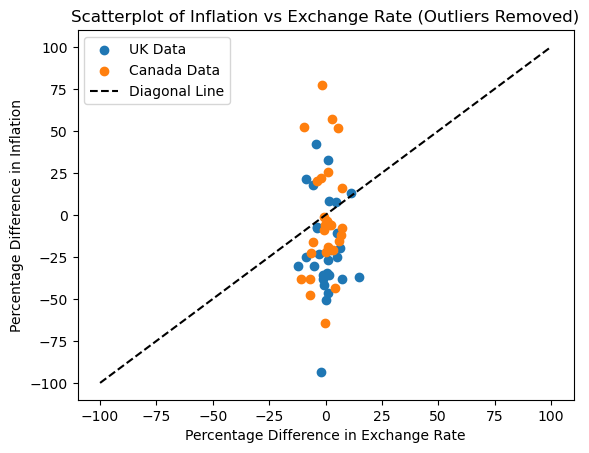

In [159]:
# Extract x and y values from the filtered DataFrame
filtered_pct_dif_infl_UKUS = filtered_ppp['UK_pct_dif_from_USA_CPI']
filtered_pct_dif_ex_UKUS = filtered_ppp['USUK_EX_DIF'] 
filtered_pct_dif_infl_CAUS = filtered_ppp['CA_pct_dif_from_USA_CPI']
filtered_pct_dif_ex_CAUS = filtered_ppp['CAUS_EX_DIF']
filtered_ppp['x_diagonal'] = np.linspace(-100, 100, 28)
filtered_ppp['y_diagonal'] = filtered_ppp['x_diagonal']

# Create a scatterplot
plt.scatter(filtered_pct_dif_ex_UKUS, filtered_pct_dif_infl_UKUS, label="UK Data")
plt.scatter(filtered_pct_dif_ex_CAUS, filtered_pct_dif_infl_CAUS, label="Canada Data")

# Add the diagonal line
plt.plot(filtered_ppp['x_diagonal'], filtered_ppp['y_diagonal'], color='black', linestyle='--', label='Diagonal Line')

# Add labels and title
plt.xlabel('Percentage Difference in Exchange Rate')
plt.ylabel('Percentage Difference in Inflation')
plt.title('Scatterplot of Inflation vs Exchange Rate (Outliers Removed)')

# Add legend
plt.legend()

# Show the plot
plt.show()

# Conclusion

ADD CONCISE CONLUSION.